## ECE176 Final Project VAE
### Eric Chen
### A16420083

This project attempt to train a Variational Encoder which generates Mel Spectrograms for music synthesis. We train the model on a dataset of music from two distinct genres (traditional Chinese and electronic) and finetune it using the music from one particular artist. We hope that the synthesized sample can exhibit features of both genres in the style of the desired artist.

**Disclaimer: The soundtracks utilized in this project are the property of their respective owners and copyright holders. I do not claim any ownership over the music used for model training. This project is strictly for educational and research purposes only, with no commercial intent or application. All music and related materials remain the intellectual property of their original creators.**

In [6]:
#imports
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [7]:
init_mem = torch.cuda.memory_allocated()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)  

cuda:0


In [3]:
class MelSpecDataset(Dataset):
    def __init__(self, directory, transform = None):
        self.file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        mel_spec = np.load(self.file_paths[idx])

        spec_min = np.min(mel_spec)
        spec_max = np.max(mel_spec)
        mel_spec_norm = (mel_spec - spec_min) / (spec_max - spec_min + 1e-6)

        if self.transform:
            mel_spec_norm = self.transform(mel_spec_norm)
        return mel_spec_norm, spec_min, spec_max

class Trim(object):
    def __init__(self, new_width):
        self.new_width = new_width

    def __call__(self, tensor):
        return tensor[:,:,:self.new_width]
    
spec_path = 'C:/Eric/UCSD/ECE/ECE176_Final/dataset/hoyo/spectrograms'

# Create the dataset and dataloader
transform = transforms.Compose([transforms.ToTensor()])
dataset = MelSpecDataset(spec_path, transform=transform)

# 7/2/1 split
train_len = int(0.8 * len(dataset))
valid_len = int(0.1 * len(dataset))
test_len = len(dataset) - train_len - valid_len

# Split the dataset
train_set, valid_set, test_set = random_split(dataset, [train_len, valid_len, test_len])

# Create the dataloaders
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True)

In [4]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        #nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class encBlock(nn.Module):

    def __init__(self, in_channels, stride=1):
        super().__init__()

        channels = in_channels*stride

        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)
        #nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        #nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class decBlock(nn.Module):

    def __init__(self, in_channels, stride=1):
        super().__init__()

        channels = int(in_channels/stride)

        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        #nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()

        if stride == 1:
            self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
            #nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
            self.bn1 = nn.BatchNorm2d(channels)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_channels, channels, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(channels)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_channels, channels, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(channels)
            )

    def forward(self, x):
        out = self.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class RN18E(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], latent_dim=100, nc=1):
        super().__init__()
        self.in_planes = 64
        self.latent_dim = latent_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        #nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(encBlock, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(encBlock, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(encBlock, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(encBlock, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512*8*41, 2*latent_dim)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()

    def _make_layer(self, encBlock, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [encBlock(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.latent_dim]
        logvar = x[:, self.latent_dim:]
        return mu, logvar

class RN18D(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], latent_dim=100, nc=1):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(latent_dim, 512*8*41)

        self.layer4 = self._make_layer(decBlock, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(decBlock, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(decBlock, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(decBlock, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=4)

        self.sigmoid = nn.Sigmoid()

    def _make_layer(self, decBlock, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [decBlock(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(x.size(0), 512, 8, 41)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = self.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 1, 256, -1)
        return x

class VAE(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = RN18E(latent_dim=latent_dim)
        self.decoder = RN18D(latent_dim=latent_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)

        #zero pad or trim to the right
        if x.size(3) > x_recon.size(3):
            pad = x.size(3) - x_recon.size(3)
            x_recon = F.pad(x_recon, (0, pad, 0, 0))
        elif x.size(3) < x_recon.size(3):
            x_recon = x_recon[:,:,:,:x.size(3)]
            
        return x_recon, mu, logvar
    
    def loss(self, x, x_recon, mu, log_var):

        #recontruction loss
        bce_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='sum')
        mse_loss = F.mse_loss(x_recon, x, reduction='sum')

        #kl divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) + 1e-10 - (log_var + 1e-10).exp())

        return mse_loss + kl_loss
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        epsilon = torch.randn_like(std)
        return epsilon * std + mu
    
    def sample(self, mu, logvar): 
        z = self.reparameterize(mu, logvar) 
        x_recon = self.decoder(z)
        return x_recon
    
def he_initialization(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

# Create the model
torch.cuda.empty_cache()
latent_dim = 100
vae = VAE(latent_dim).to(device)
vae.apply(he_initialization)

#model summary
final_mem = torch.cuda.memory_allocated()
model_mem = final_mem - init_mem
model_memory_mb = model_mem / (1024 ** 2)
print(f'Memory allocated to model: {model_memory_mb} Mb')
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f'Model Parameters {num_params}')

Memory allocated to model: 285.8125 Mb
Model Parameters 74259529


In [5]:
def train_vae(model, train_loader,epoch, print_freq, optimizer):
    avg_losses = []   # Avg. losses.
    #torch.autograd.set_detect_anomaly(True)
    for i, data in enumerate(train_loader, 0):
        inputs = data[0].to(device)
        optimizer.zero_grad()
        recon, mu, log_var = model(inputs)
        #print('recon',recon.size())    #for debugging
        #print('input',inputs.size())
        #print(recon.min(), recon.max())
        #break
        loss = vae.loss(inputs, recon, mu, log_var)
        loss.backward()

        #for params in model.parameters():
        #    torch.nn.utils.clip_grad_norm_(params, max_norm=1)

        optimizer.step()
        avg_losses.append(loss.item() / len(inputs))

        if i % print_freq == 0:
            print(f'Epoch:{epoch} [{i}/{len(train_loader)}] Loss: {avg_losses[-1]}')

        epoch_train_loss = sum(avg_losses) / len(avg_losses)
    return vae, epoch_train_loss

def validate_vae(model, valid_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            inputs = data[0].to(device)

            recon, mu, log_var = model(inputs)

            loss = model.loss(inputs, recon, mu, log_var)

            total_loss += loss.item() * inputs.size(0)

    avg_loss = total_loss / len(valid_loader.dataset)

    return avg_loss

def test_vae(model, test_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            inputs = data[0].to(device)

            recon, mu, log_var = model(inputs)

            loss = model.loss(inputs, recon, mu, log_var)

            total_loss += loss.item() * inputs.size(0)

    avg_loss = total_loss / len(test_loader.dataset)

    return avg_loss

#### Finetuning

In [19]:
from torch.optim.lr_scheduler import StepLR

# train the model for n epochs
epochs = 50  
print_freq = 100  # Print frequency.
optimizer = optim.Adam(vae.parameters(), lr=1e-5)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
#load model
checkpoint = torch.load('msVAE_tuned.pth')
vae.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer.param_groups[0]['lr'] = 1e-6
vae.train()

VAE(
  (encoder): RN18E(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): encBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (shortcut): Sequential()
      )
      (1): encBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [ ]:

training_losses = []
for epoch in range(epochs):
    vae, training_loss = train_vae(vae, train_loader, epoch, print_freq, optimizer)
    training_losses.append(training_loss)
    print(f'Epoch {epoch} Training Loss: {training_loss:.4f}')
    valid_loss = validate_vae(vae, valid_loader)
    print(f'Epoch {epoch} Validation Loss: {valid_loss:.4f}')
    scheduler.step()

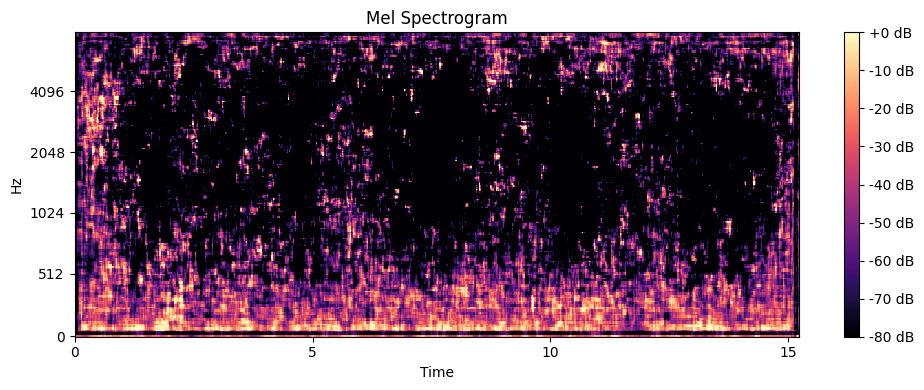

Playing: Generated sample from VAE...
MelSpec Dimensions: (256, 1312)


In [20]:
#generate samples
def generate_sample(model, latent_dim):
    mu = torch.randn([1, latent_dim]).to(device) 
    logvar = torch.randn([1, latent_dim]).to(device)

    with torch.no_grad(): 
        sample = model.sample(mu, logvar)
    
    return sample

# Assuming your model and latent_dim are defined
melspec_gen = generate_sample(vae, latent_dim)
# plot and play the generated sample
import librosa
from IPython.display import Audio


melspec_gen = melspec_gen.detach().cpu().numpy().squeeze()
scaled_melspec_gen = melspec_gen
mel_spec_db = librosa.power_to_db(scaled_melspec_gen, ref=np.max)

# Convert melspec to wave
audio = librosa.feature.inverse.mel_to_audio(melspec_gen, sr=44100, n_fft=2048, hop_length=512)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=44100, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

print(f"Playing: Generated sample from VAE...")
print(f"MelSpec Dimensions: {melspec_gen.shape}")
Audio(audio, rate=44100)

In [ ]:
#fine tuning dataset
spec_path = 'C:/Eric/UCSD/ECE/ECE176_Final/dataset/hoyo/spectrograms'

# Create the dataset and dataloader
transform = transforms.Compose([transforms.ToTensor()])
dataset = MelSpecDataset(spec_path, transform=transform)

# 8/1/1 split
train_len = int(0.8 * len(dataset))
valid_len = int(0.1 * len(dataset))
test_len = len(dataset) - train_len - valid_len

# Split the dataset
train_set, valid_set, test_set = random_split(dataset, [train_len, valid_len, test_len])

# Create the dataloaders
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True)

In [ ]:
#final save
model_state_dict = vae.state_dict()
optimizer_state_dict = optimizer.state_dict()

torch.save({
    'model_state_dict': model_state_dict,
    'optimizer_state_dict': optimizer_state_dict,
}, 'msVAE_tuned.pth')